In [164]:
#common packages we basically always need
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from time import time
from sklearn import tree
import scipy.sparse as ss
import math

In [165]:
#load data, in sparse format
def load_data(filename):
    f = open('dorothea/%s.data' % filename)
    I,J = [],[]
    for k in range(100000):
        line = f.readline()
        if len(line) == 0:
            print('done')
            break

        line = [int(x) for x in line.split()]
        J.extend(line)
        I.extend(k for i in range(len(line)))

    return ss.coo_matrix((np.ones(len(I)), (I,J)))


def load_labels(filename):
    f = open('dorothea/%s.labels' % filename)
    y = []
    for k in range(100000):
        line = f.readline()
        
        if len(line) == 0:
            print('done')
            break
        y.append(int(line))
    return np.array(y)


Xtrain = load_data('dorothea_train')
ytrain = load_labels('dorothea_train')

Xtest= load_data('dorothea_valid')
ytest = load_labels('dorothea_valid')

print( Xtrain.shape,  Xtest.shape, Xtrain.nnz)

done
done
done
done
(800, 100001) (350, 100001) 727760


In [166]:
print(Xtrain)

  (0, 191)	1.0
  (0, 367)	1.0
  (0, 614)	1.0
  (0, 634)	1.0
  (0, 711)	1.0
  (0, 1202)	1.0
  (0, 1220)	1.0
  (0, 1311)	1.0
  (0, 1472)	1.0
  (0, 1730)	1.0
  (0, 2281)	1.0
  (0, 2572)	1.0
  (0, 2602)	1.0
  (0, 2611)	1.0
  (0, 2824)	1.0
  (0, 2855)	1.0
  (0, 2940)	1.0
  (0, 3149)	1.0
  (0, 3313)	1.0
  (0, 3560)	1.0
  (0, 3568)	1.0
  (0, 3824)	1.0
  (0, 4185)	1.0
  (0, 4266)	1.0
  (0, 4366)	1.0
  :	:
  (799, 97876)	1.0
  (799, 97899)	1.0
  (799, 98032)	1.0
  (799, 98266)	1.0
  (799, 98277)	1.0
  (799, 98301)	1.0
  (799, 98342)	1.0
  (799, 98353)	1.0
  (799, 98413)	1.0
  (799, 98419)	1.0
  (799, 98448)	1.0
  (799, 98458)	1.0
  (799, 98468)	1.0
  (799, 98635)	1.0
  (799, 98892)	1.0
  (799, 99118)	1.0
  (799, 99337)	1.0
  (799, 99621)	1.0
  (799, 99625)	1.0
  (799, 99739)	1.0
  (799, 99745)	1.0
  (799, 99755)	1.0
  (799, 99828)	1.0
  (799, 99955)	1.0
  (799, 99967)	1.0


In [167]:
def get_class_balance(y):
    #y is a vector
    countOfOnes = np.sum(y==1)
    countOfTwos = np.sum(y==-1)
    return (countOfOnes, countOfTwos) #returns a tuple of both

print ('class balance is currently %.2f  +1, %.2f -1' % get_class_balance(ytrain))
print ('class balance is currently %.2f  +1, %.2f -1' % get_class_balance(ytrain))

class balance is currently 78.00  +1, 722.00 -1
class balance is currently 78.00  +1, 722.00 -1


0.04125 0.7724137931034484
0.07428571428571429 0.5806451612903226


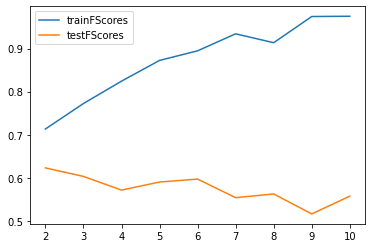

In [168]:
def get_misclass(y,yhat):
    #y is a vector
    #yhat is a vector
    falsepositive, falsenegative = np.sum((y==-1) & (yhat==1)), np.sum((y==1) & (yhat==-1))
    truepositive, truenegative = np.sum((y==1) & (yhat==1)), np.sum((y==-1) & (yhat==-1)) 
    sumNegatives = falsepositive + falsenegative
    return sumNegatives / len(y)

def get_f1(y,yhat):
    falsepositive, falsenegative = np.sum((y==-1) & (yhat==1)), np.sum((y==1) & (yhat==-1))
    truepositive, truenegative = np.sum((y==1) & (yhat==1)), np.sum((y==1) & (yhat==-1)) 
    precision = truepositive / (truepositive + falsepositive)
    recall = truepositive / (truepositive + falsenegative)
    f1Score = (2 * (precision * recall)) / (precision + recall)
    return f1Score

depth = 3
clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth, class_weight='balanced')
clf = clf.fit(Xtrain, ytrain)

print( get_misclass(ytrain, clf.predict(Xtrain) ), get_f1(ytrain, clf.predict(Xtrain) ))
print (get_misclass(ytest, clf.predict(Xtest) ), get_f1(ytest, clf.predict(Xtest) ))

trainOfF1, testofF1 = [], []
for i in range(2, 11):
    clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=i, class_weight='balanced')
    clf = clf.fit(Xtrain, ytrain)
    trainOfF1.append(get_f1(ytrain, clf.predict(Xtrain)))
    testofF1.append(get_f1(ytest, clf.predict(Xtest)))

plt.plot(range(2, len(trainOfF1) + 2),trainOfF1, label='trainFScores')
plt.plot(range(2, len(testofF1) + 2),testofF1, label='testFScores')
plt.legend()

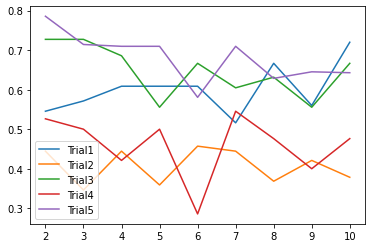

In [169]:
#K cross validation
#paritioned xtrain into k splits(5) 
splitX = np.array_split(Xtrain.A, 5) #.A to turn into matrix
splitY = np.array_split(ytrain, 5)

def combineMatrix(new_train_arr_x):
    finalArr = []
    for arr in new_train_arr_x:
        finalArr.extend(arr)
    return finalArr

def deleteArrInMiddle(new_train_arr_x, i):
    newArr = new_train_arr_x[:i]
    if len(new_train_arr_x) > i:
        newArr += new_train_arr_x[i+1:]
    return newArr

kFoldArrFinal = []
tempAppendArr = []

for i in range(5): #K folds
    tempAppendArr = []
    for depth in range(2,11): #For each depth
        getTrainArrX = deleteArrInMiddle(splitX, i)
        getTrainArrX2 = combineMatrix(getTrainArrX) #Join them back because split turned it into an array of arrays
        cooGetTrainArrX = ss.coo_matrix(getTrainArrX2) #Makes it a coo matrix
        getTrainArrY = deleteArrInMiddle(splitY, i)
        getTrainArrY = combineMatrix(getTrainArrY) #Join them back because split turned it into an array of arrays
        #####################################################
        clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth, class_weight='balanced')
        clf = clf.fit(cooGetTrainArrX, getTrainArrY)
        tempAppendArr.append(get_f1(splitY[i], clf.predict(splitX[i])))

    kFoldArrFinal.append(tempAppendArr)

i = 1
for line in kFoldArrFinal:
    string = 'Trial' + str(i)
    plt.plot(range(2,11),line, label=string)
    plt.legend()
    i += 1

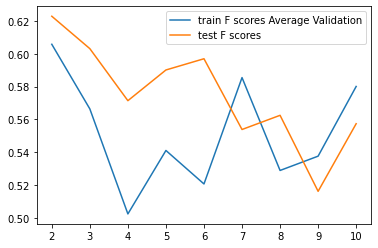

In [170]:
#K cross validation
#paritioned xtrain into k splits(5) 
splitX = np.array_split(Xtrain.A, 5) #.A to turn into matrix
splitY = np.array_split(ytrain, 5)

def combineMatrix(new_train_arr_x):
    finalArr = []
    for arr in new_train_arr_x:
        finalArr.extend(arr)
    return finalArr

def deleteArrInMiddle(new_train_arr_x, i):
    newArr = new_train_arr_x[:i]
    if len(new_train_arr_x) > i:
        newArr += new_train_arr_x[i+1:]
    return newArr

kFoldArrFinal = []
tempAppendArr = []

for depth in range(2,11): #K folds
    tempAppendArr = []
    for i in range(0,5): #For each depth
        getTrainArrX = deleteArrInMiddle(splitX, i)
        getTrainArrX2 = combineMatrix(getTrainArrX) #Join them back because split turned it into an array of arrays
        cooGetTrainArrX = ss.coo_matrix(getTrainArrX2) #Makes it a coo matrix
        getTrainArrY = deleteArrInMiddle(splitY, i)
        getTrainArrY = combineMatrix(getTrainArrY) #Join them back because split turned it into an array of arrays
        #####################################################
        clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth, class_weight='balanced')
        clf = clf.fit(cooGetTrainArrX, getTrainArrY)
        tempAppendArr.append(get_f1(splitY[i], clf.predict(splitX[i])))

    kFoldArrFinal.append(np.mean(tempAppendArr))

plt.plot(range(2, len(trainOfF1) + 2), kFoldArrFinal, label='train F scores Average Validation')
plt.plot(range(2, len(testofF1) + 2),testofF1, label='test F scores')
plt.legend()